# How to Become a Data Scientist
***

**Jack Cook — 11/08/17**

Kaggle recently conducted a [survey](https://www.kaggle.com/kaggle/kaggle-survey-2017) to gauge the state of data science and machine learning. They received nearly 17,000 responses, and left us with a lot to analyze. Rather than finding summary statistics about the survey's respondents, I figured I'd try to specifically see how these results could be useful to people like me, who are figuring out how to get started.

If you're not that interested in the analysis, and just want to **see the results of the collective recommendations of 17,000 industry professionals**, feel free to [click here](#conclusion) to skip to the end. Otherwise, stick around to see how I reached these conclusions.

# Table of Contents

* [1. Importing and preprocessing](#importing_and_preprocessing)
  * [1.1. Importing data](#importing_data)
  * [1.2. Data preprocessing](#data_preprocessing)
  * [1.3. Theme](#theme)
* [2. Getting started](#getting_started)
  * [2.1. Programming language](#programming_language)
  * [2.2. Majors and likely positions](#majors_and_likely_positions)
* [3. What to learn about](#what_to_learn_about)
  * [3.1. Resources for learning](#resources_for_learning)
  * [3.2. Important job skills](#important_job_skills)
  * [3.3. Tools in the real world](#tools_in_the_real_world)
  * [3.4. Important job methods](#important_job_methods)
* [4. Conclusion](#conclusion)

# 1. Importing and Preprocessing
<a id="importing_and_preprocessing"></a>

## 1.1. Importing data
<a id="importing_data"></a>

In [1]:
library(data.table)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(tibble)

results <- as.tibble(suppressWarnings(fread("./data/multipleChoiceResponses.csv")))

## 1.2. Data preprocessing
<a id="data_preprocessing"></a>

Many of the job titles and majors that are referred to throughout this analysis have very long names. I reduced the length of a few of them to make the graphs more readable, removed illegal characters from two work methods, and converted job satisfaction into a numeric.

In [2]:
results$CurrentJobTitleSelect[results$CurrentJobTitleSelect == "Software Developer/Software Engineer"] <- "Software Engineer"
results$CurrentJobTitleSelect[results$CurrentJobTitleSelect == "Operations Research Practitioner"] <- "Operations Research"

results$MajorSelect[results$MajorSelect == "Engineering (non-computer focused)"] <- "Engineering"
results$MajorSelect[results$MajorSelect == "Information technology, networking, or system administration"] <- "Information technology"
results$MajorSelect[results$MajorSelect == "Management information systems"] <- "Information systems"

results_names <- names(results)
results_names[results_names == "WorkMethodsFrequencyA/B"] <- "WorkMethodsFrequencyABTesting"
results_names[results_names == "WorkMethodsFrequencyCross-Validation"] <- "WorkMethodsFrequencyCrossValidation"
names(results) <- results_names

results$JobSatisfaction <- suppressWarnings(as.numeric(substr(results$JobSatisfaction, start = 1, stop = 2)))

## 1.3. Theme
<a id="theme"></a>

I have multiple data displays throughout the analysis, and I think there's something to be said about making graphs look nice. I'll be building off of this theme for most of my graphs.

In [3]:
jack_theme <- theme(
    plot.background = element_rect(fill = "#eeeeee"),
    panel.background = element_rect(fill = "#eeeeee"),
    legend.background = element_rect(fill = "#eeeeee"),
    legend.title = element_text(size = 12, family = "Helvetica", face = "bold"),
    legend.text = element_text(size = 9, family = "Helvetica"),
    panel.grid.major = element_line(size = 0.4, linetype = "solid", color = "#cccccc"),
    panel.grid.minor = element_line(size = 0),
    plot.title = element_text(size = 20, family = "Helvetica", face = "bold", hjust = 0.5, margin = margin(b = 20)),
    axis.title = element_text(size = 14, family = "Helvetica", face = "bold"),
    axis.title.x = element_text(margin = margin(t = 20)),
    axis.title.y = element_text(margin = margin(r = 20)),
    axis.ticks = element_blank(),
    plot.margin = unit(c(1, 1, 1, 1), "cm")
)

# 2. Getting started
<a id="getting_started"></a>

## 2.1. Programming language
<a id="programming_language"></a>

One of the first questions many beginner data scientists will ask themselves is what programming language they should learn. In this graph, we can see how Python and R stacked up against each other based on recommendations by participents with each job title.

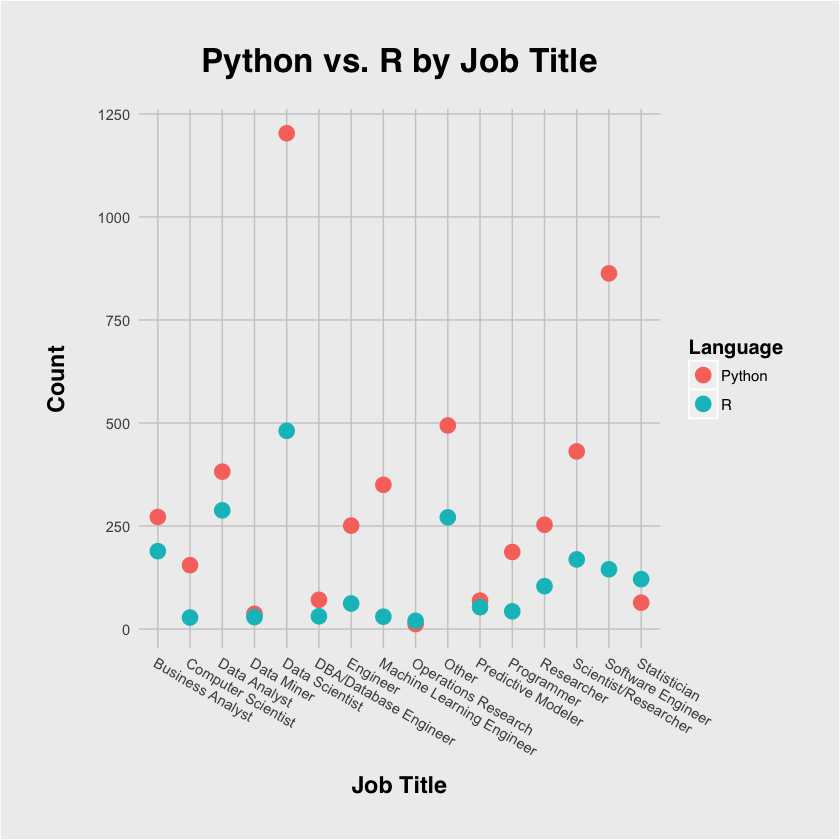

In [4]:
results %>%
    rename(Language = LanguageRecommendationSelect, title = CurrentJobTitleSelect) %>%
    filter(Language == "R" | Language == "Python") %>%
    filter(title != "") %>%
    group_by(title, Language) %>%
    count() %>%
    ggplot(aes(title, n, color = Language)) +
    ggtitle("Python vs. R by Job Title") +
    labs(x = "Job Title", y = "Count") +
    geom_point(size = 4) +
    jack_theme +
    theme(
        axis.text.x = element_text(angle = 330, hjust = 0),
        axis.title.x = element_text(margin = margin(t = 12))
    )

As we can see, **Python is favored for beginners over R in almost every scenario**, and notably so for data scientists, software developers, and machine learning engineers. However, R is very slightly favored by statisticians. It is technically favored for operations researchers as well, but I would attribute this to a very small sample size.

## 2.2. Majors and likely positions
<a id="majors_and_likely_positions"></a>

I haven't started college yet, and as such, have not yet had to declare a major. However, intuitively I would think that some majors are much more likely than others to hold certain jobs. In this next graph, we can confirm or disprove my beliefs, seeing what proportion of each job title is held by people with a certain major.

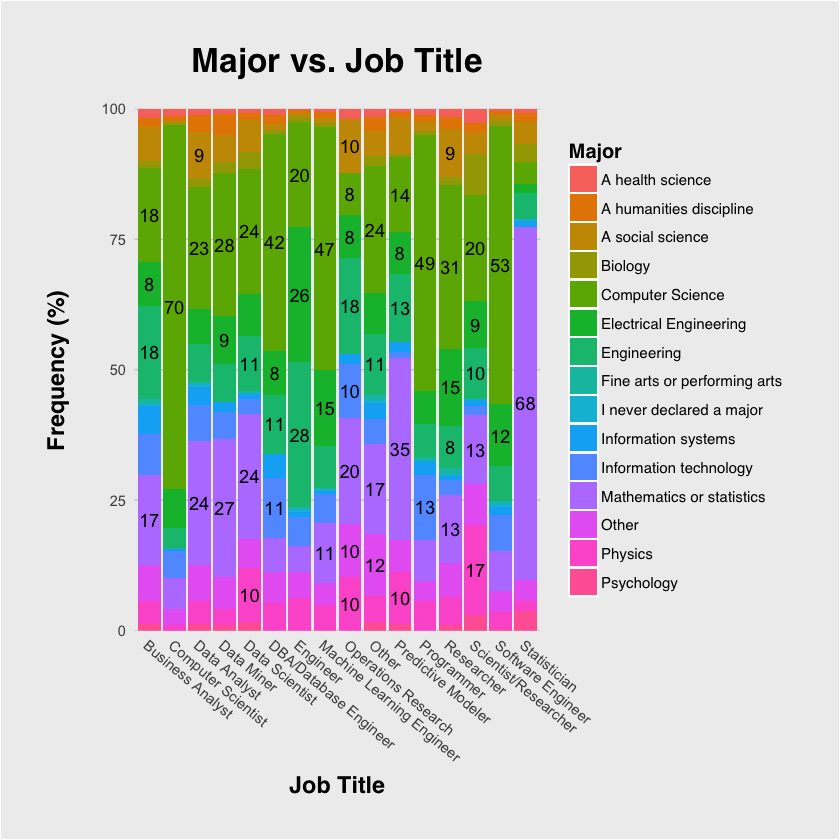

In [5]:
results %>%
    rename(Major = MajorSelect, title = CurrentJobTitleSelect) %>%
    filter(title != "", Major != "") %>%
    group_by(title, Major) %>%
    summarize(n = n()) %>%
    mutate(freq = n / sum(n) * 100) %>%
    ggplot(aes(x = title, y = freq, fill = Major, label = ifelse(freq > 8, round(freq), ""))) +
    ggtitle("Major vs. Job Title") +
    labs(x = "Job Title", y = "Frequency (%)") +
    geom_bar(stat = "identity", position = position_stack()) +
    geom_text(position = position_stack(vjust = 0.5)) +
    scale_y_continuous(expand = c(0, 0)) +
    jack_theme +
    theme(
        axis.title.x = element_text(margin = margin(t = 8)),
        axis.text.x = element_text(angle = 320, hjust = 0)
    )

My intuitions were mostly right, majors end up being a pretty good predictor of what someone will do in the future. A few of these trends are obvious: computer science majors tend to become computer scientists, programmers, and software engineers, while math majors tend to become statisticians and predictive modelers. Most physics majors go into research, and non-CS engineering majors called themselves engineers.

What I personally like about this graph is, and this is true, **at least one person from each major is fulfilling every job title**. To me, this shows that no matter what you study in school, you can do what you want as long as the passion is there.

# 3. What to learn about
<a id="what_to_learn_about"></a>

## 3.1. Resources for learning
<a id="resources_for_learning"></a>

One of the survey's first questions asked participants how useful certain resources are for learning about data science. In this next graph, I plotted each resource's usefulness against its popularity. Popularity is the number of people who responded to this question, and usefulness is a weighted average of the responses given and the number of respondents. Each person got either a weight of 1 for an answer of "very useful", 0.5 for an answer of "somewhat useful", or no weight at all if they said it wasn't useful. In this graph, we can not only see the most useful resources out there, but also if any resources are overhyped or underutilized.

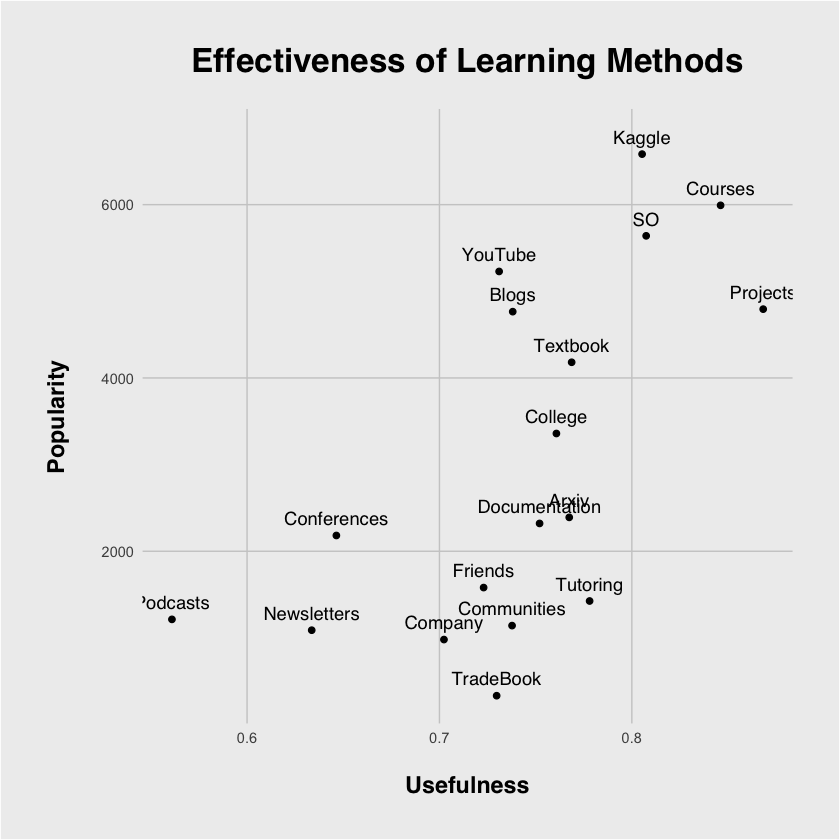

In [6]:
# Get all column names that begin with "LearningPlatformUsefulness"
platforms <- grep("^LearningPlatformUsefulness", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 0 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 1) / popularity
    
    names <- c(names, gsub("LearningPlatformUsefulness", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Effectiveness of Learning Methods") +
    geom_point() +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 200) +
    jack_theme

We can see a couple of results that are immediately obvious. Podcasts, newsletters, and conferences all scored the lowest as far as how useful they are for learning, while **Kaggle competitions, Stack Overflow, online courses, and projects scored the highest**. We can also see that while many people love watching YouTube tutorials and reading blogposts, these may not be the most effective ways to learn about data science.

## 3.2. Important job skills
<a id="important_job_skills"></a>

We can reuse the same method used to create the last graph to make another graph for the questions that asked which technologies were considered to be the most important on the job. Here, I plotted popularity against usefulness again to see which technologies are used the most in the real world.

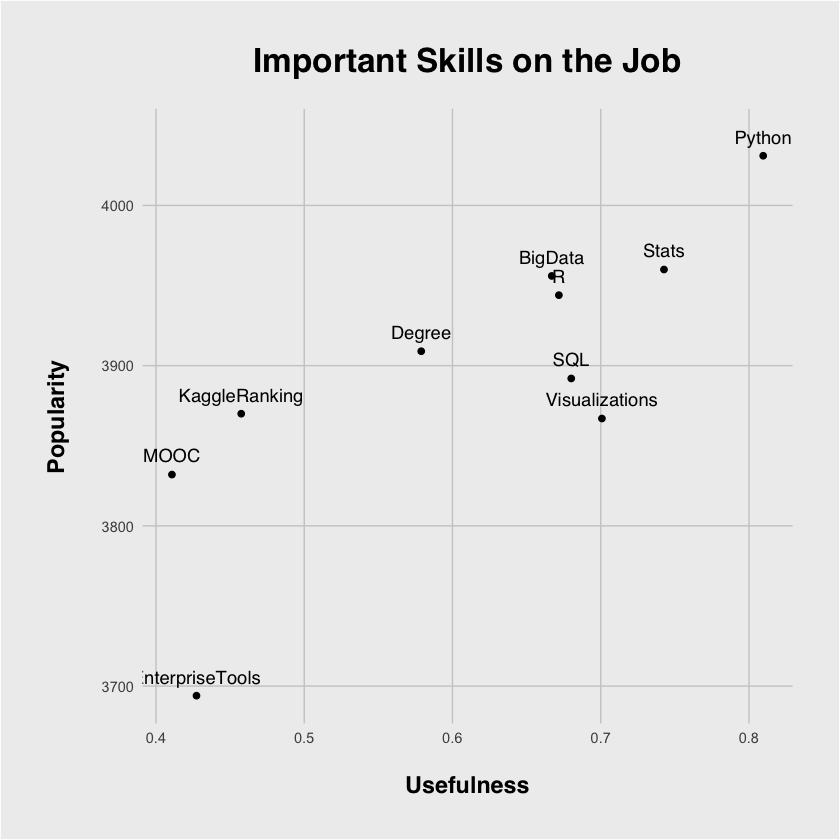

In [7]:
# Get all column names that begin with "JobSkillImportance" and end in a letter
platforms <- grep("^JobSkillImportance.*[A-z]$", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 0) / popularity
    
    names <- c(names, gsub("JobSkillImportance", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Important Skills on the Job") +
    geom_point() +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 12) +
    jack_theme

Interestingly enough, MOOCs scored the lowest in terms of usefulness, even while online courses scored the second highest in the last question. Therefore, while courses can be good for learning about data science, maybe other resources should be used in order to learn skills that are useful for your job. We can see that **knowledge of Python, advanced statistics, and vizualization tools ranked the highest** in terms of skills that are useful in getting data science jobs.

## 3.3. Tools in the real world
<a id="tools_in_the_real_world"></a>

One of the survey's questions involved asking respondents how often they used certain technologies at work. Instead of making a scatterplot for this one, I put them into a table with multiple columns for job titles, since the responses essentially measured popularity anyway. More weight was given to technologies that were reportedly used more often, and by more people.

In [8]:
# Get all column names that begin with "WorkToolsFrequency" and end in a letter
platforms <- grep("^WorkToolsFrequency.*[A-z]$", names(results), value=T)
positions <- c("All", "Data Scientist", "Software Engineer", "Researcher", "Machine Learning Engineer")

technologies <- matrix("", 10, length(positions))
colnames(technologies) <- positions
rownames(technologies) <- 1:10

i <- 1

for (position in positions) {
    names <- c()
    popularities <- c()
    
    if (position == "All") {
        position_results <- results
    } else {
        position_results <- results %>% filter(CurrentJobTitleSelect == position)
    }
    
    for (platform in platforms) {
        usefulness <- position_results %>%
            group_by_(platform) %>%
            count()
        
        # Popularity = the number of people who responded to this question
        popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4] + usefulness[[2]][5]
        
        # Usefulness = a weighted average determining how much this tool was used
        score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.67 + usefulness[[2]][4] * 0.33 + usefulness[[2]][5] * 0) / popularity
        
        names <- c(names, as.character(gsub("WorkToolsFrequency", "", platform)))
        popularities <- c(popularities, popularity * score)
    }
    
    scores_df <- data.frame(
        Popularity = popularities,
        Name = names
    )
    
    technologies[, i] <- head(as.character((scores_df %>% arrange(desc(Popularity)))$Name), n = 10)
    i <- i + 1
}

technologies

,All,Data Scientist,Software Engineer,Researcher,Machine Learning Engineer
1,Python,Python,Python,Python,Python
2,SQL,SQL,SQL,R,Jupyter
3,R,R,Jupyter,Jupyter,TensorFlow
4,Jupyter,Jupyter,Unix,MATLAB,Unix
5,Unix,Unix,Java,TensorFlow,SQL
6,TensorFlow,AWS,AWS,SQL,R
7,AWS,Spark,NoSQL,Unix,AWS
8,Tableau,TensorFlow,R,C,C
9,Java,Hadoop,TensorFlow,Java,Java
10,NoSQL,Tableau,C,Excel,MATLAB


Here, we can see a couple of insightful trends. **Python, SQL, R, Jupyter, Unix, and TensorFlow are all ubiquitous.** However, Spark, Hadoop, and Tableau are unique to data scientists, NoSQL is unique to software engineers, and MATLAB is unique to researchers and machine learning engineers. While some of these could have been guessed, this is confirmation of the tools that are good to learn for anyone aspiring to have one of these jobs in the future.

## 3.4. Important job methods
<a id="important_job_methods"></a>

Again, we can make the same table as we did for the previous questions, but for methods used on the job rather than skills. Here, we see the top 10 methods used for all respondents, and then by the same four job titles that we isolated in the last question.

In [9]:
# Get all column names that begin with "WorkToolsFrequency" and end in a letter
methods <- grep("^WorkMethodsFrequency.*[A-z]$", names(results), value=T)
positions <- c("All", "Data Scientist", "Software Engineer", "Researcher", "Machine Learning Engineer")

technologies <- matrix("", 10, length(positions))
colnames(technologies) <- positions
rownames(technologies) <- 1:10

i <- 1

for (position in positions) {
    names <- c()
    popularities <- c()
    
    if (position == "All") {
        position_results <- results
    } else {
        position_results <- results %>% filter(CurrentJobTitleSelect == position)
    }
    
    for (method in methods) {
        usefulness <- position_results %>%
            group_by_(method) %>%
            count()
        
        # Popularity = the number of people who responded to this question
        popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4] + usefulness[[2]][5]
        
        # Usefulness = a weighted average determining how much this tool was used
        score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.67 + usefulness[[2]][4] * 0.33 + usefulness[[2]][5] * 0) / popularity
        
        names <- c(names, as.character(gsub("WorkMethodsFrequency", "", method)))
        popularities <- c(popularities, popularity * score)
    }
    
    scores_df <- data.frame(
        Popularity = popularities,
        Name = names
    )
    
    technologies[, i] <- head(as.character((scores_df %>% arrange(desc(Popularity)))$Name), n = 10)
    i <- i + 1
}

technologies

,All,Data Scientist,Software Engineer,Researcher,Machine Learning Engineer
1,DataVisualization,DataVisualization,DataVisualization,DataVisualization,CrossValidation
2,CrossValidation,CrossValidation,CrossValidation,CrossValidation,NeuralNetworks
3,LogisticRegression,LogisticRegression,NeuralNetworks,NeuralNetworks,DataVisualization
4,DecisionTrees,RandomForests,LogisticRegression,LogisticRegression,CNNs
5,RandomForests,DecisionTrees,DecisionTrees,PCA,NLP
6,TimeSeriesAnalysis,TimeSeriesAnalysis,TimeSeriesAnalysis,TimeSeriesAnalysis,LogisticRegression
7,NeuralNetworks,TextAnalysis,TextAnalysis,CNNs,RandomForests
8,PCA,EnsembleMethods,RandomForests,DecisionTrees,DecisionTrees
9,TextAnalysis,PCA,NLP,SVMs,PCA
10,KNN,GBM,ABTesting,NLP,EnsembleMethods


We can see a number of trends in this table as well. **Everyone is using data visualization, cross validation, logistic regression, and decision trees.** Natural language processing and neural networks are understandably used more often by machine learning engineers, while software engineers are the only job title where A/B testing made an appearance.

# 4. Conclusion
<a id="conclusion"></a>

If you're a novice data scientist and you're just looking for somewhere to get started, the graphs we created strongly support a couple of recommendations:

1. **Learn Python.** Both Python and R have been around for decades, but as we can see in [the first graph](#programming_language), Python won out in basically every scenario. This is also backed up by [the fourth graph](#important_job_skills), in which participants overwhelmingly said that Python was the most important skill on the job. I honestly believe you will be hard-pressed to find a company that doesn't use Python at all, so you should be good to go.
2. **Major in CS and Math.** As I mentioned just after creating the [graph of majors vs. job titles](#majors_and_likely_positions), every major has some presence in every role. However, judging from the proportions visible on the bar graph, CS majors and math majors are the most abundant in almost every role. Although it's not a requirement, either or both these majors may give you a bit of an edge.
3. **Make projects, take courses, and participate in Kaggle challenges.** As we could see in [the graph analyzing the best resources for learning](#resources_for_learning), there were a couple of very clear winners. Creating projects, taking online courses, and participating in Kaggle challenges all took the cake as the three most useful resources for learning about data science.
4. **Learn about the most widely used tools.** There seems to be a neverending supply of data science tools and libraries, but this survey allowed us to see the ones that were considered the most important. The most recommended tools were Python, SQL, R, Jupyter, and Unix ([click here to see more](#tools_in_the_real_world)), and the most recommended methods to learn were data visualization, [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), [decision trees](https://en.wikipedia.org/wiki/Decision_tree), and [random forests](https://en.wikipedia.org/wiki/Random_forest) ([click here to see more](#important_job_methods)).

Hopefully this helps you figure out where you should get started! I wouldn't consider myself a professional, but if you have any questions, I'll do my best to answer them in the comments. Thanks for reading!